# Comparing the effect of hard vs. soft boundary and initial conditions

## Problem Setup
We solve: $\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$

 - **Forward Problem**: Given $\alpha$, find $u(x,t)$
 - **Inverse Problem**: Given measurements of $u$, find $\alpha$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from data.heat_data import HeatEquationData
from models.heat_pinn import HeatPINN
from models.heat_pinn_hard_bc import HeatPINNHardBC
from training.trainer import PINNTrainer
from training.trainer_hard_bc import PINNTrainerHardBC
from results.plotter import plot_solution

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Imports successful.")

Imports successful.


## Step 1: Generate Data

Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 1.0% (SNR ≈ 40 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 40.3 dB

Dataset generation complete.


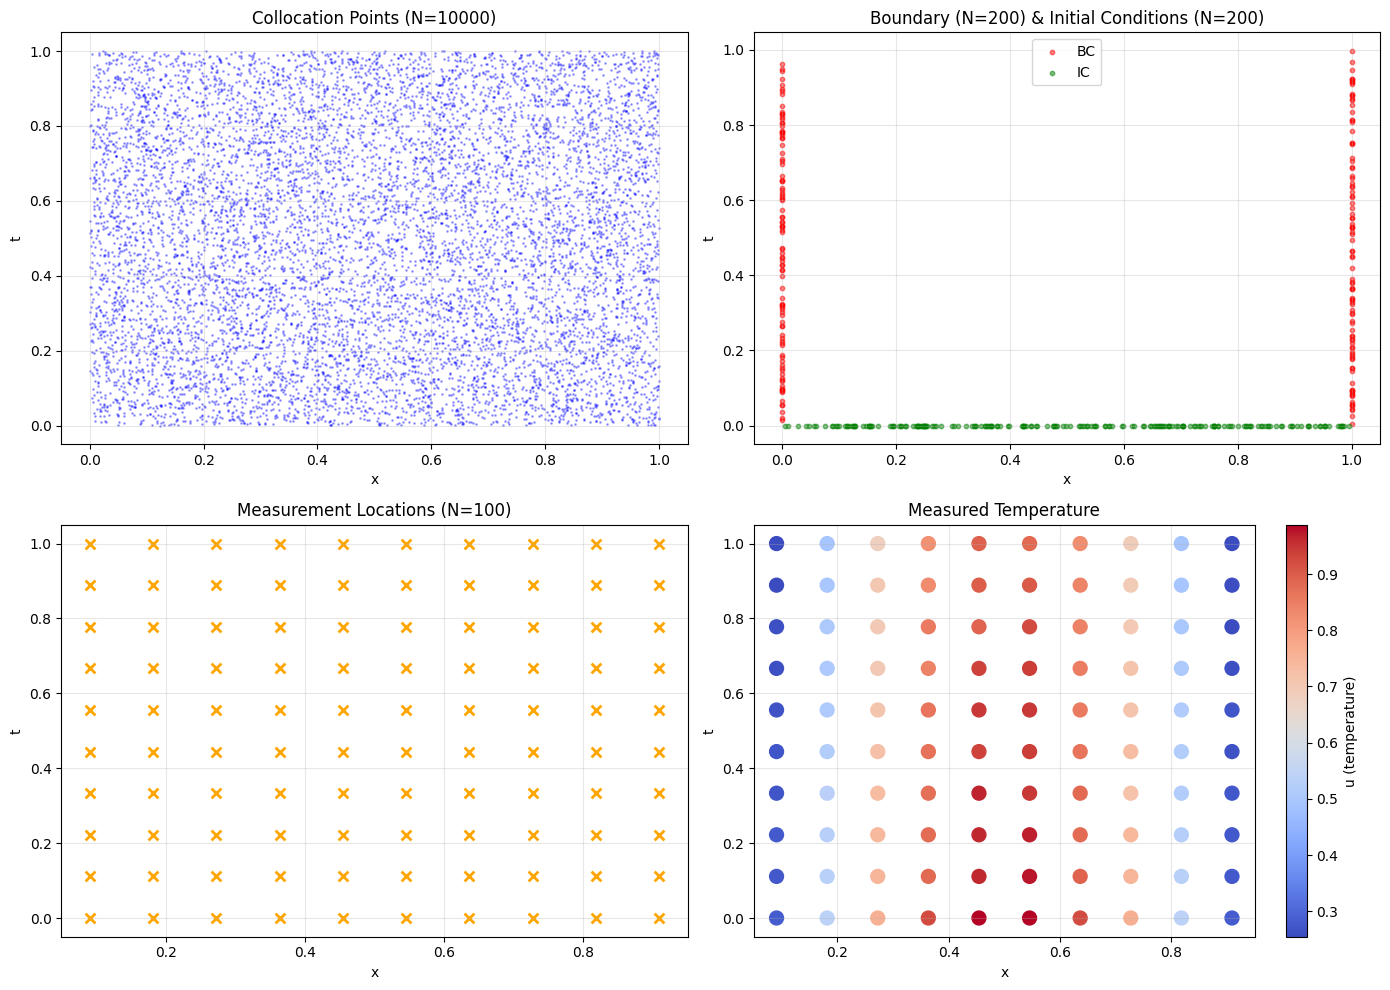

In [2]:
data_gen = HeatEquationData(
    L=1.0,                  # Domain length
    T=1.0,                  # Final time
    alpha=0.01,             # True thermal diffusivity
    N_f=10000,              # Collocation points
    N_bc = 100,             # BC points
    N_ic = 200,             # IC points
    N_sensors=10,           # Sensor locations
    N_time_measurements=10, # Time measurements
    noise_level=0.01,       # 1% noise (SNR ~ 40 dB)
    device='cpu'
)

# Generate complete dataset
data = data_gen.generate_full_dataset(collocation_method='uniform')

# Visualize the data
data_gen.visualize_data(data)

## Step 2: Train Forward Problem

Here we solve for $u(x,t)$ given known $\alpha = 0.01$

### Soft constraints: fixed weights

In [3]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

Forward problem mode: alpha fixed to 0.01


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 7.799184e-01
  Residual: 3.642399e-04 (λ=1.00)
  Boundary: 4.342730e-02 (λ=1.00)
  Initial: 7.361268e-01 (λ=1.00)

Epoch 1000/5000 (55.6s)
  Adam learning rate: 1.00e-03
  Total Loss: 2.935953e-04
  Residual: 1.056388e-04 (λ=1.00)
  Boundary: 6.532913e-05 (λ=1.00)
  Initial: 1.226274e-04 (λ=1.00)

Epoch 2000/5000 (103.4s)
  Adam learning rate: 1.00e-03
  Total Loss: 6.808015e-05
  Residual: 2.574606e-05 (λ=1.00)
  Boundary: 1.277820e-05 (λ=1.00)
  Initial: 2.955589e-05 (λ=1.00)


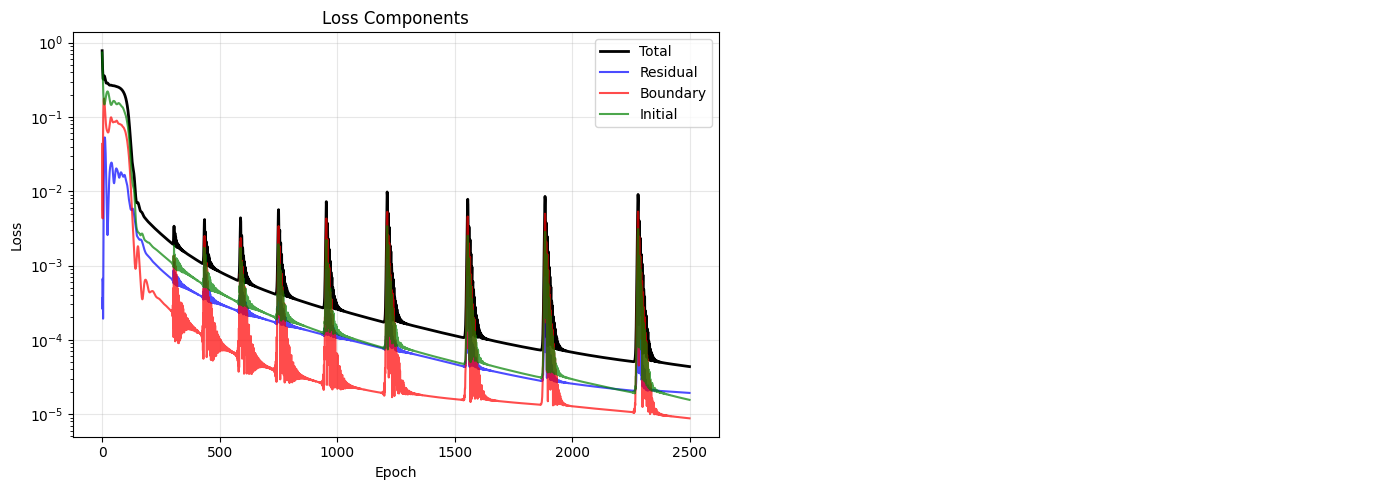


Epoch 3000/5000 (155.2s)
  Adam learning rate: 1.00e-03
  Total Loss: 2.980997e-05
  Residual: 1.610084e-05 (λ=1.00)
  Boundary: 5.493638e-06 (λ=1.00)
  Initial: 8.215499e-06 (λ=1.00)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at epoch 3742
  Variance ratio: 0.093916 < 0.1
  Slope (log): |-0.000600| < 0.001

Final training plot:


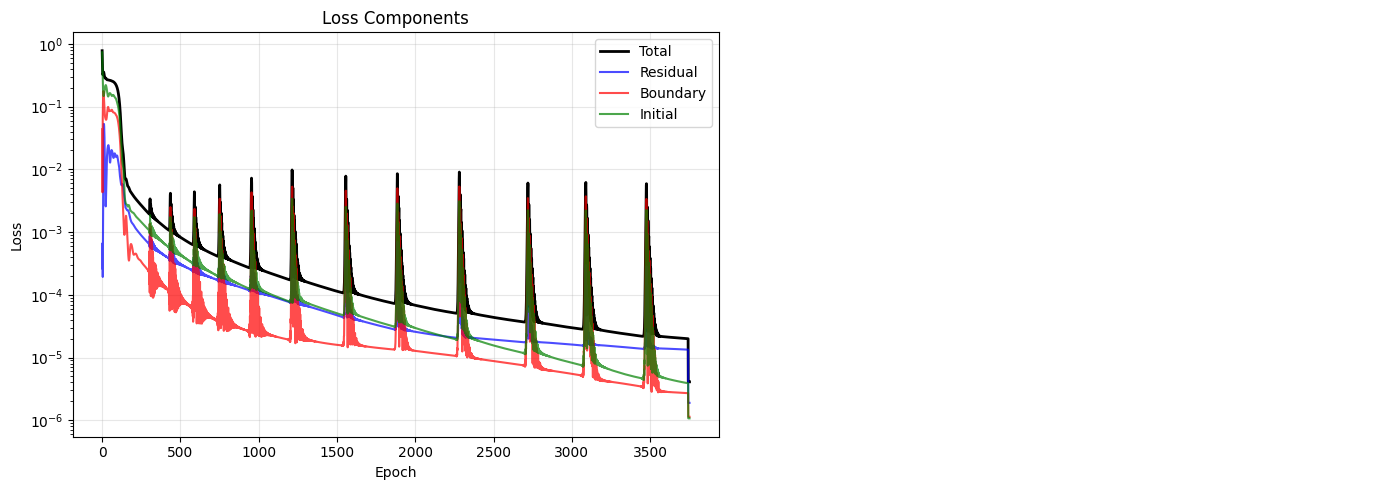


Training complete. Total time: 206.8s


In [4]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    switch_var=0.1,
    switch_slope=0.001,
    adaptive_weights=False,
)

# Train for 5000 epochs
trainer_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Visualize

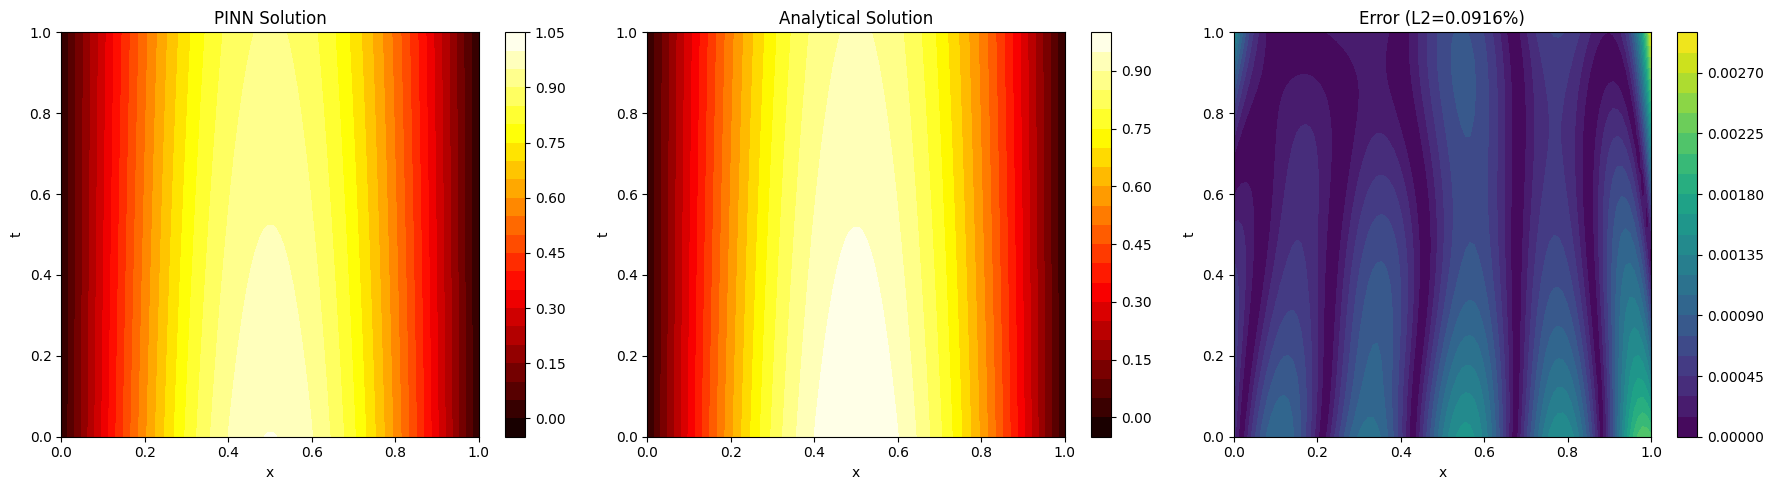

In [5]:
plot_solution(model_forward, data, alpha_true=0.01, save_path='../results/hard_vs_soft/forward_5k_no_aw_reconstruct_soft.png')

### Soft constraints: adaptive weights

In [6]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

Forward problem mode: alpha fixed to 0.01


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 8.925540e-01
  Residual: 7.416567e-02 (λ=1.00)
  Boundary: 9.310022e-02 (λ=1.00)
  Initial: 7.252881e-01 (λ=1.00)

Epoch 1000/5000 (65.6s)
  Adam learning rate: 1.00e-03
  Total Loss: 2.880595e-04
  Residual: 3.218109e-05 (λ=2.50)
  Boundary: 1.852170e-04 (λ=0.74)
  Initial: 8.773802e-05 (λ=0.80)

Epoch 2000/5000 (131.7s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.664355e-05
  Residual: 5.103290e-06 (λ=2.54)
  Boundary: 2.826535e-06 (λ=0.74)
  Initial: 1.979777e-06 (λ=0.80)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at epoch 2321
  Variance ratio: 0.091019 < 0.1
  Slope (log): |-0.000515| < 0.001

Final training plot:


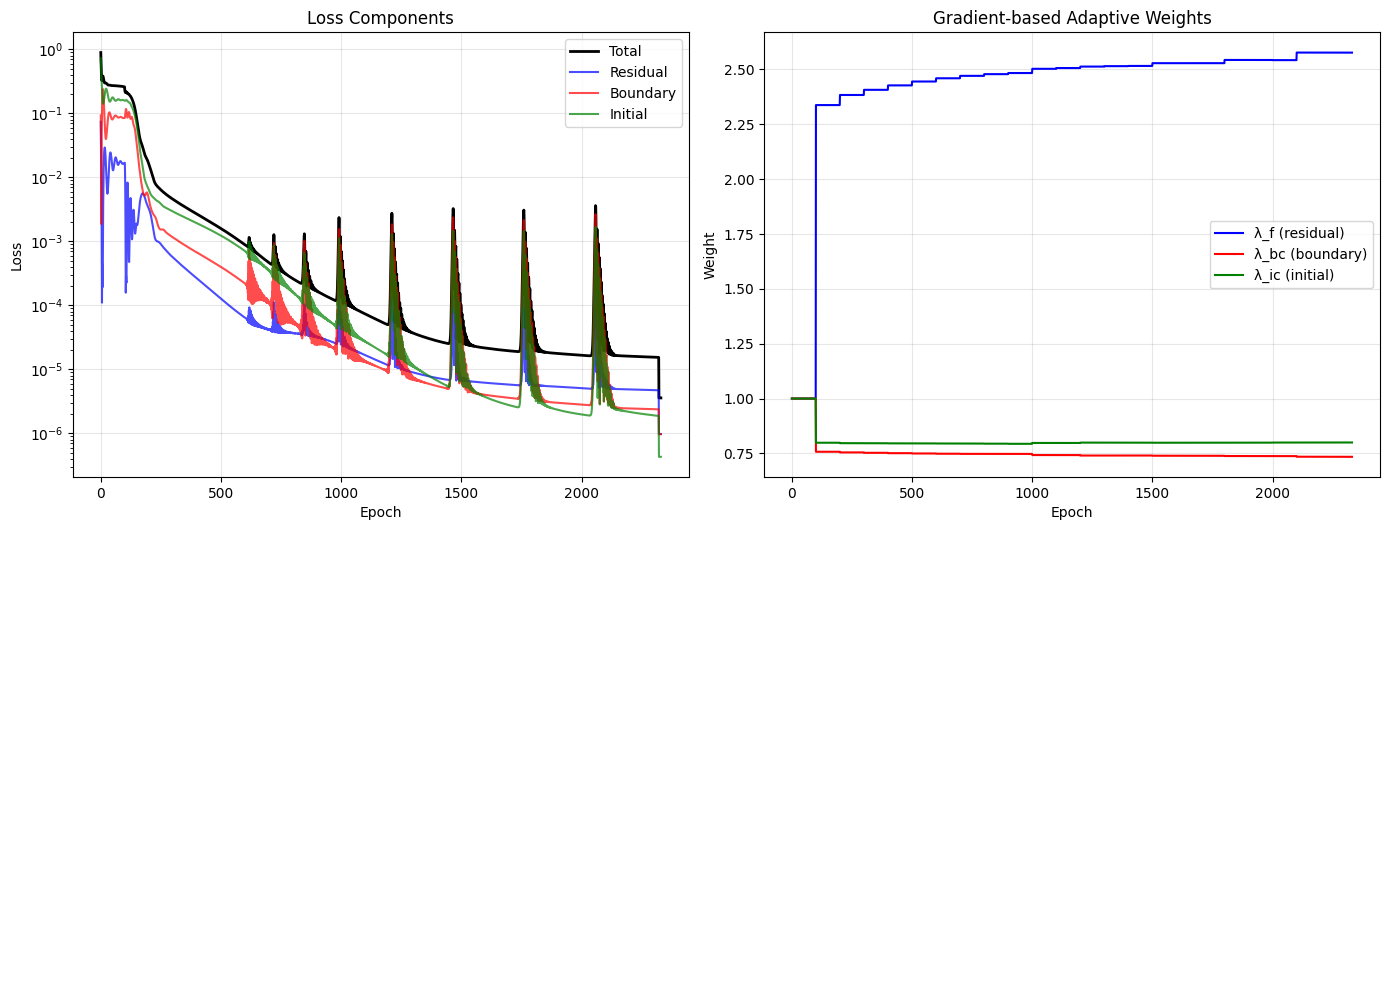


Training complete. Total time: 160.8s


In [7]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    switch_var=0.1,
    switch_slope=0.001,
    adaptive_weights=True,
)

# Train for 5000 epochs
trainer_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Visualize

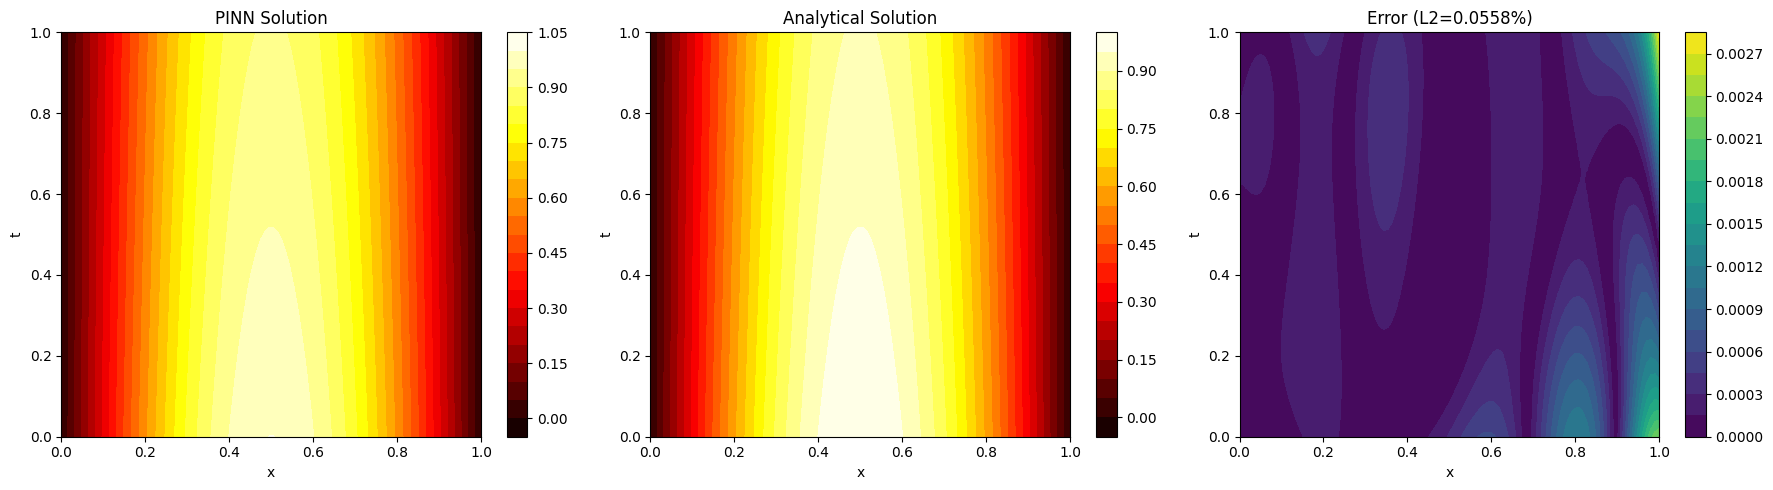

In [8]:
plot_solution(model_forward, data, alpha_true=0.01, save_path='../results/hard_vs_soft/forward_5k_aw_reconstruct_soft.png')

### Hard constraints

There is only one loss function with hard constraints so adaptive weights has no effect

In [9]:
model_forward_hard = HeatPINNHardBC(
    ic_func=lambda x: torch.sin(torch.pi * x),
    bc_left_func=lambda t: torch.zeros_like(t),
    bc_right_func=lambda t: torch.zeros_like(t),
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

Forward problem mode with hard BCs: alpha fixed to 0.01


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 4.853880e-01
  Residual: 4.853880e-01 (λ=1.00)

Epoch 1000/5000 (79.9s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.343167e-04
  Residual: 1.343167e-04 (λ=1.00)

Epoch 2000/5000 (159.3s)
  Adam learning rate: 1.00e-03
  Total Loss: 9.681206e-06
  Residual: 9.681206e-06 (λ=1.00)


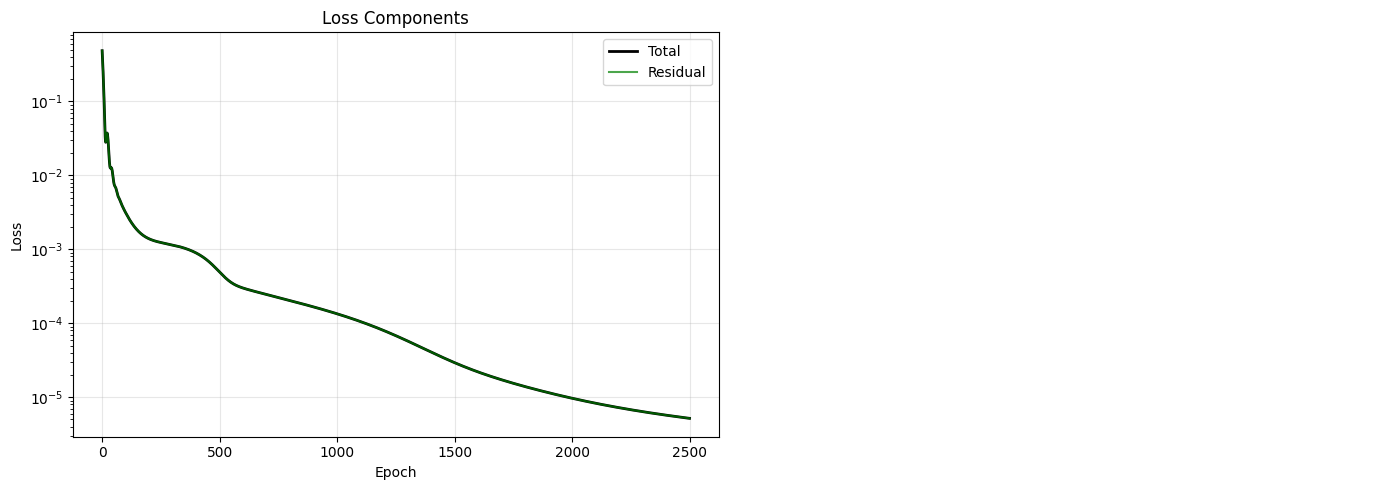


Epoch 3000/5000 (231.6s)
  Adam learning rate: 1.00e-03
  Total Loss: 3.433012e-06
  Residual: 3.433012e-06 (λ=1.00)

Epoch 4000/5000 (303.9s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.544651e-06
  Residual: 1.544651e-06 (λ=1.00)

Final training plot:


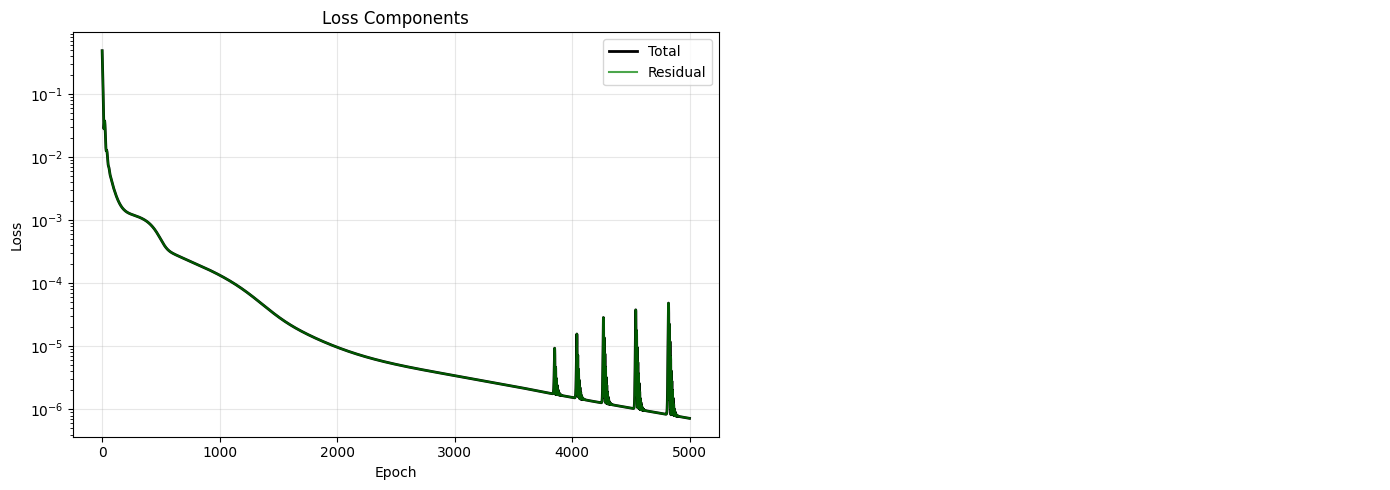

Max IC error (L1) after training: 0.0
Max BC errors (L1) after training: Left: 0.0, Right: 8.739753809550166e-08

Training complete. Total time: 384.7s


In [10]:
trainer_forward_hard = PINNTrainerHardBC(
    model=model_forward_hard,
    data=data,
    device='cpu',
    switch_var=0.1,
    switch_slope=0.001,
    adaptive_weights=False,
)

# Train for 5000 epochs
trainer_forward_hard.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Visualize

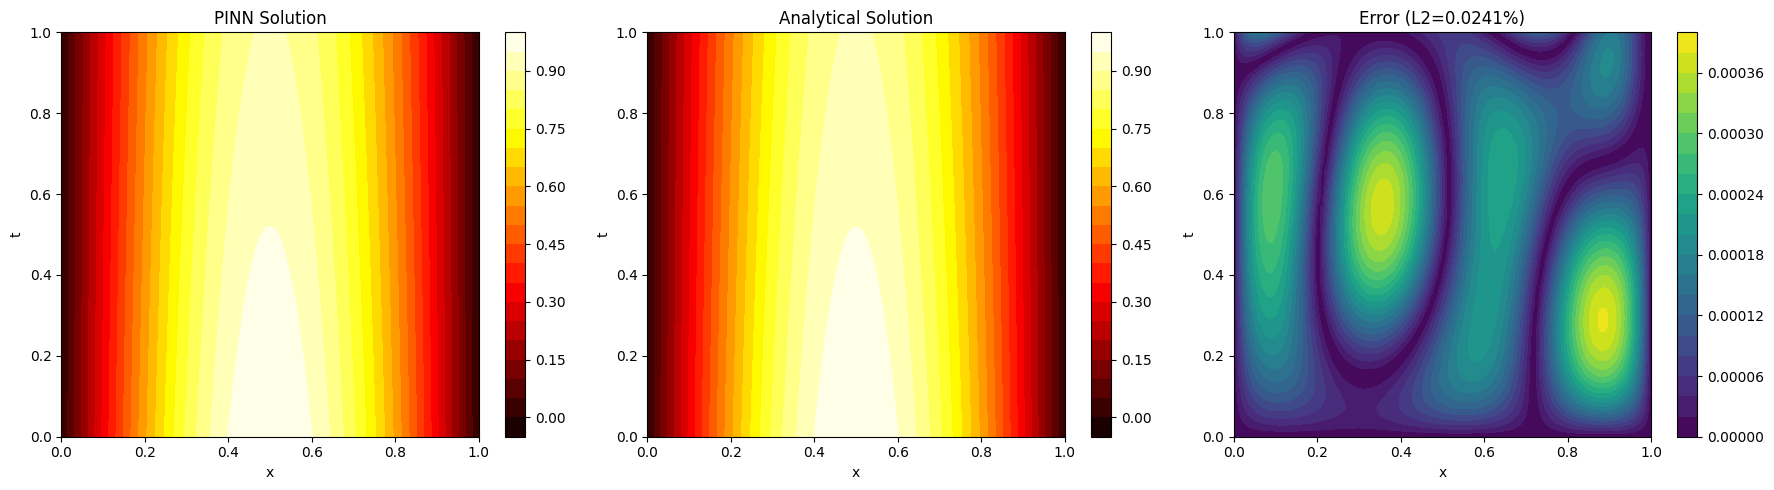

In [11]:
plot_solution(model_forward_hard, data, alpha_true=0.01, save_path='../results/hard_vs_soft/forward_5k_reconstruct_hard.png')

## Step 3: Train Inverse Problem

Now we recover $\alpha$ from noisy measurements of $u(x,t)$

### Soft constraints: fixed weights

In [12]:
model_inverse = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02
)

Inverse problem mode: alpha initialized to 0.02


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 7.913212e-01
  Residual: 1.240345e-01 (λ=1.00)
  Boundary: 3.243552e-01 (λ=1.00)
  Initial: 2.230853e-01 (λ=1.00)
  Measurement: 1.198460e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Epoch 1000/5000 (54.4s)
  Adam learning rate: 1.00e-03
  Total Loss: 5.743691e-04
  Residual: 1.336948e-04 (λ=1.00)
  Boundary: 6.014416e-05 (λ=1.00)
  Initial: 2.014374e-04 (λ=1.00)
  Measurement: 1.790927e-04 (λ=1.00)
  Alpha: 0.008988 (true: 0.01)

Epoch 2000/5000 (112.3s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.546825e-04
  Residual: 3.533695e-05 (λ=1.00)
  Boundary: 1.730079e-05 (λ=1.00)
  Initial: 3.884692e-05 (λ=1.00)
  Measurement: 6.319780e-05 (λ=1.00)
  Alpha: 0.009661 (true: 0.01)

Switching to L-BFGS at epoch 2494
 

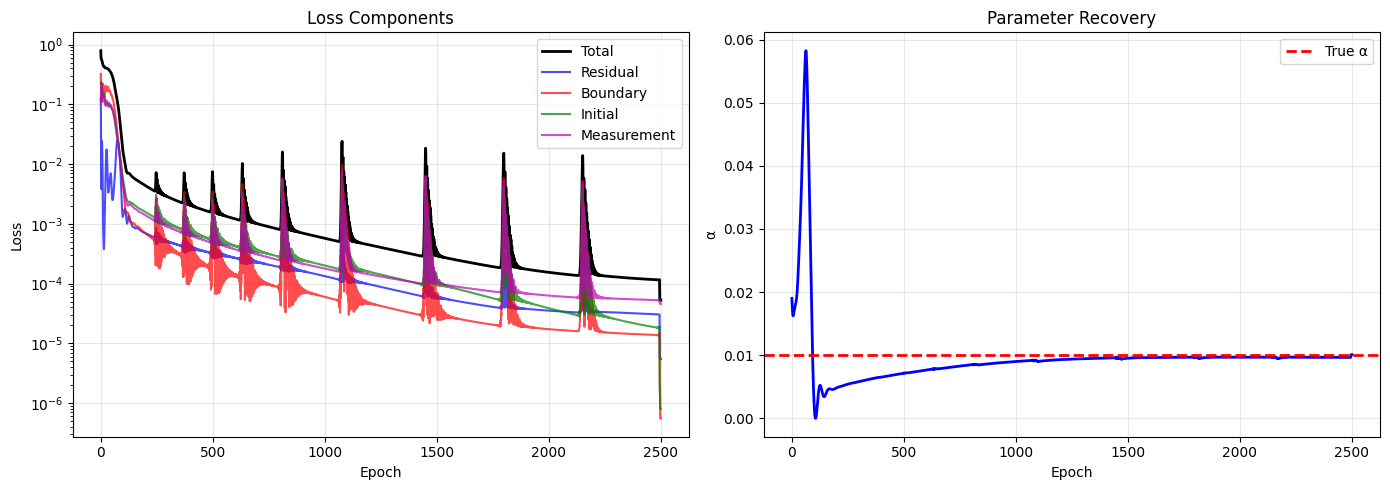


Final training plot:


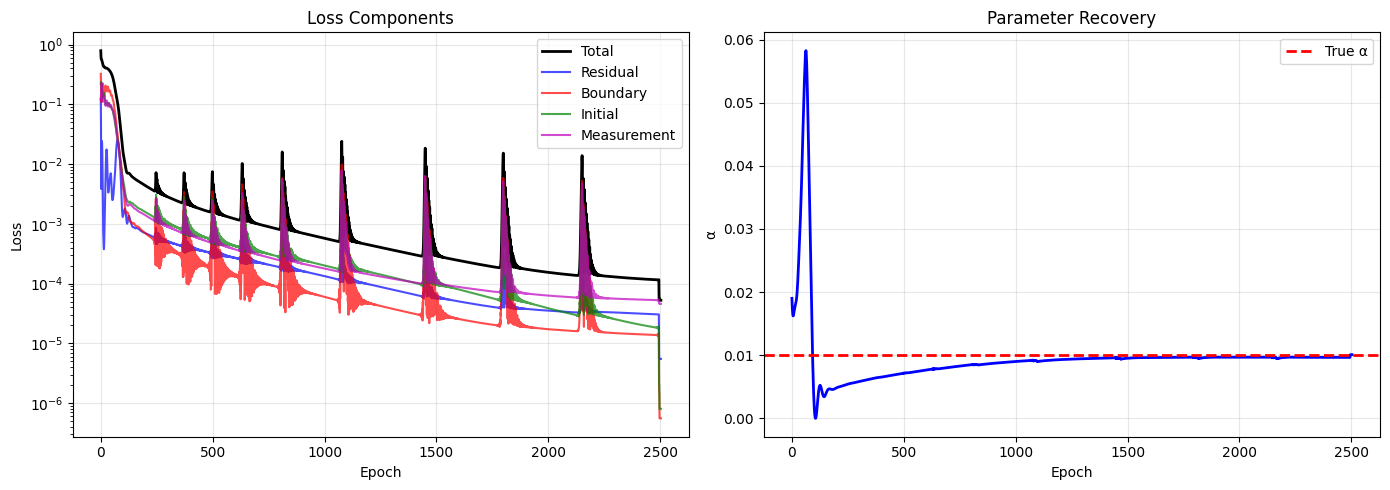


Training complete. Total time: 150.9s


In [13]:
trainer_inverse = PINNTrainer(
    model=model_inverse,
    data=data,
    device='cpu',
    switch_var=0.1,
    switch_slope=0.001,
    adaptive_weights=False,
)

trainer_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Evaluate inverse problem

In [14]:
alpha_true = 0.01
alpha_pred = model_inverse.get_alpha()
error_pct = abs(alpha_pred - alpha_true) / alpha_true * 100

print("\n" + "=" * 50)
print("INVERSE PROBLEM RESULTS")
print("=" * 50)
print(f"True α:        {alpha_true:.6f}")
print(f"Predicted α:   {alpha_pred:.6f}")
print(f"Error:         {error_pct:.2f}%")
print("=" * 50)

if error_pct < 5:
    print("SUCCESS: Parameter recovered within 5% error!")
else:
    print("Try training longer or adjusting hyperparameters")


INVERSE PROBLEM RESULTS
True α:        0.010000
Predicted α:   0.010071
Error:         0.71%
SUCCESS: Parameter recovered within 5% error!


Visualize inverse problem results

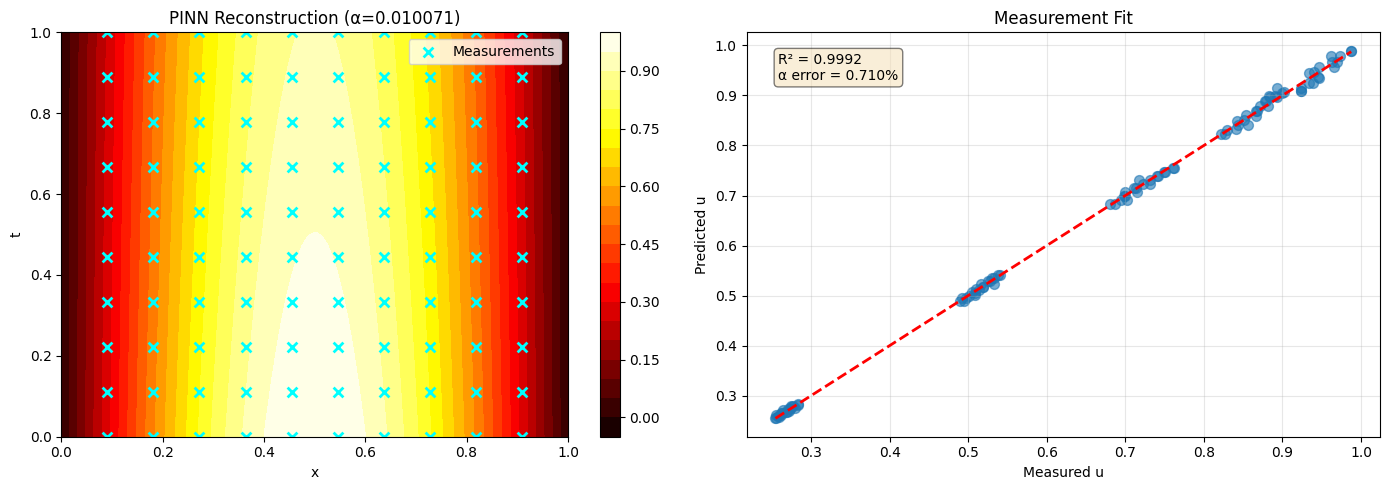

In [15]:
plot_solution(model_inverse, data, alpha_true=0.01, save_path='../results/hard_vs_soft/inverse_5k_no_aw_reconstruct_soft.png')

### Soft constraints: adaptive weights

In [16]:
model_inverse = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02
)

Inverse problem mode: alpha initialized to 0.02


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 6.090584e-01
  Residual: 1.928680e-03 (λ=1.00)
  Boundary: 2.271776e-01 (λ=1.00)
  Initial: 2.087442e-01 (λ=1.00)
  Measurement: 1.712078e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Epoch 1000/5000 (57.6s)
  Adam learning rate: 1.00e-03
  Total Loss: 7.036599e-04
  Residual: 1.548725e-04 (λ=1.27)
  Boundary: 1.798966e-04 (λ=0.53)
  Initial: 1.210916e-04 (λ=1.14)
  Measurement: 1.278090e-04 (λ=2.12)
  Alpha: 0.009261 (true: 0.01)

Epoch 2000/5000 (118.0s)
  Adam learning rate: 1.00e-03
  Total Loss: 2.079998e-04
  Residual: 2.493559e-05 (λ=1.54)
  Boundary: 4.152762e-05 (λ=0.52)
  Initial: 3.100610e-05 (λ=1.12)
  Measurement: 6.078937e-05 (λ=1.87)
  Alpha: 0

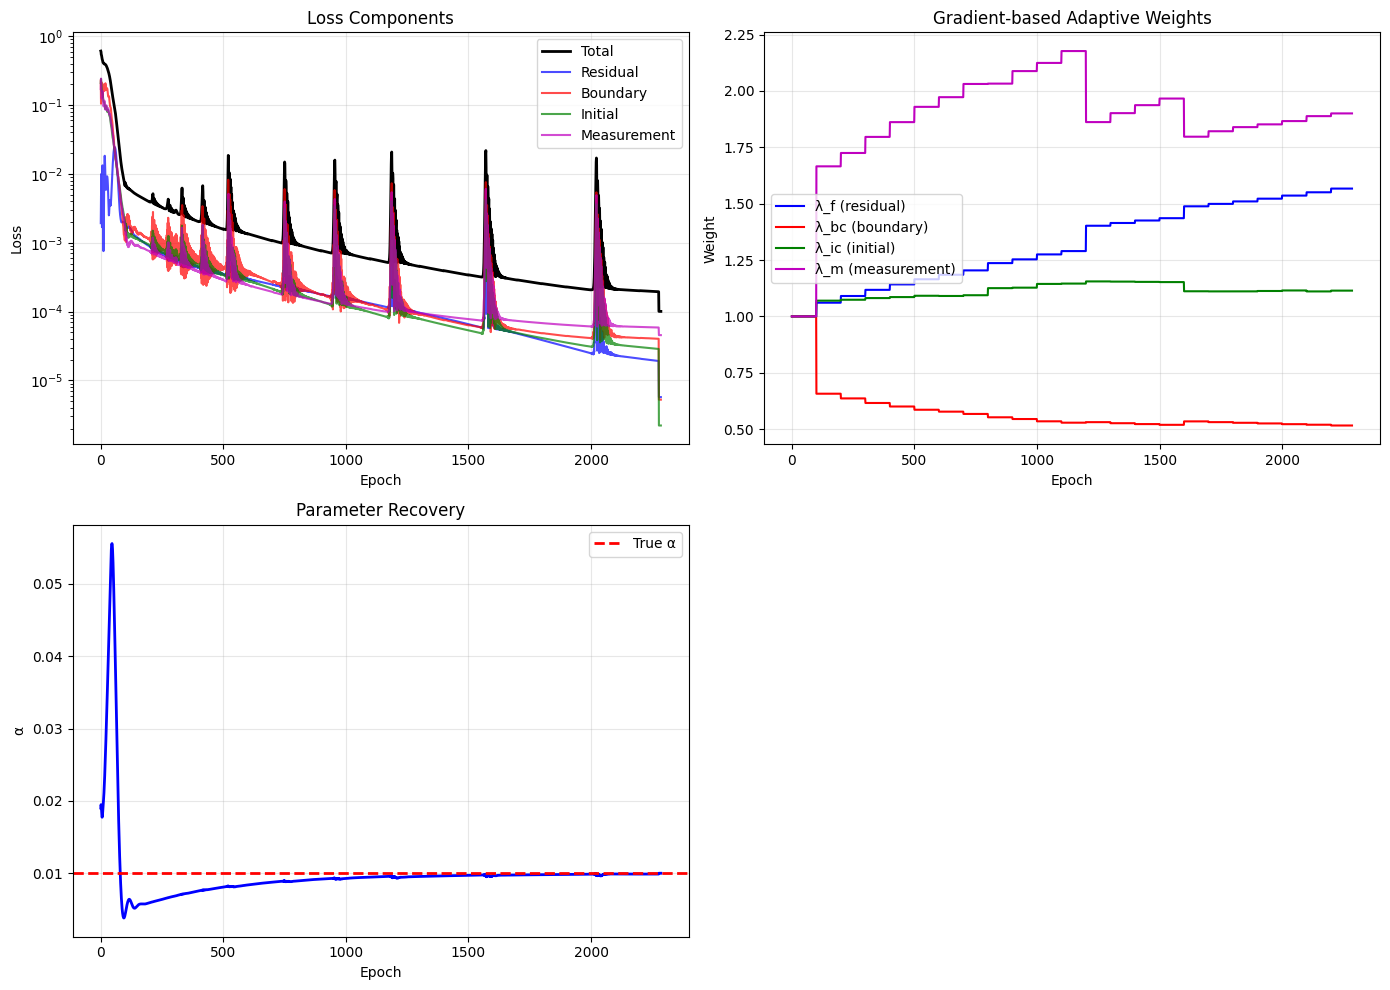


Training complete. Total time: 142.3s


In [17]:
trainer_inverse = PINNTrainer(
    model=model_inverse,
    data=data,
    device='cpu',
    switch_var=0.1,
    switch_slope=0.001,
    adaptive_weights=True,
)

trainer_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Evaluate

In [18]:
alpha_true = 0.01
alpha_pred = model_inverse.get_alpha()
error_pct = abs(alpha_pred - alpha_true) / alpha_true * 100

print("\n" + "=" * 50)
print("INVERSE PROBLEM RESULTS")
print("=" * 50)
print(f"True α:        {alpha_true:.6f}")
print(f"Predicted α:   {alpha_pred:.6f}")
print(f"Error:         {error_pct:.2f}%")
print("=" * 50)

if error_pct < 5:
    print("SUCCESS: Parameter recovered within 5% error!")
else:
    print("Try training longer or adjusting hyperparameters")


INVERSE PROBLEM RESULTS
True α:        0.010000
Predicted α:   0.009978
Error:         0.22%
SUCCESS: Parameter recovered within 5% error!


Visualize

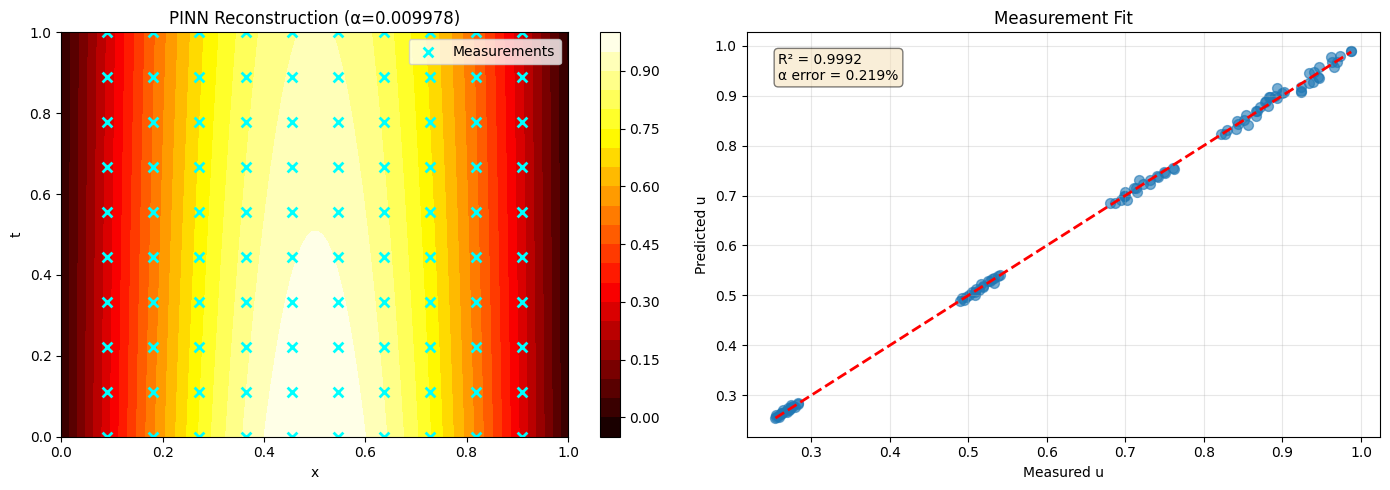

In [19]:
plot_solution(model_inverse, data, alpha_true=0.01, save_path='../results/hard_vs_soft/inverse_5k_aw_reconstruct_soft.png')

### Hard constraints: fixed weights

In [20]:
model_inverse_hard = HeatPINNHardBC(
    ic_func=lambda x: torch.sin(torch.pi * x),
    bc_left_func=lambda t: torch.zeros_like(t),
    bc_right_func=lambda t: torch.zeros_like(t),
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02
)

Inverse problem mode: alpha initialized to 0.02


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 5.496133e-01
  Residual: 3.925767e-01 (λ=1.00)
  Measurement: 1.570366e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Epoch 1000/5000 (61.4s)
  Adam learning rate: 1.00e-03
  Total Loss: 2.544395e-04
  Residual: 1.871416e-04 (λ=1.00)
  Measurement: 6.729789e-05 (λ=1.00)
  Alpha: 0.009530 (true: 0.01)

Epoch 2000/5000 (119.7s)
  Adam learning rate: 1.00e-03
  Total Loss: 7.118640e-05
  Residual: 2.262547e-05 (λ=1.00)
  Measurement: 4.856092e-05 (λ=1.00)
  Alpha: 0.010159 (true: 0.01)

Switching to L-BFGS at epoch 2297
  Variance ratio: 0.099993 < 0.1
  Slope (log): |-0.000588| < 0.001

Final training plot:


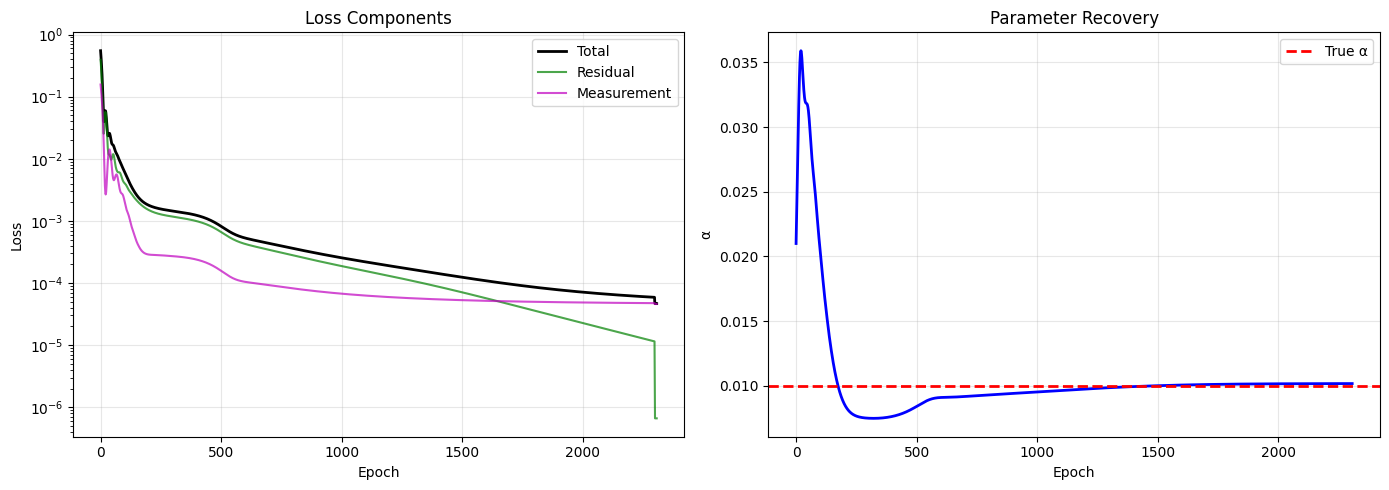

Max IC error (L1) after training: 0.0
Max BC errors (L1) after training: Left: 0.0, Right: 8.663175776746357e-08

Training complete. Total time: 142.8s


In [21]:
trainer_inverse_hard = PINNTrainerHardBC(
    model=model_inverse_hard,
    data=data,
    device='cpu',
    switch_var=0.1,
    switch_slope=0.001,
    adaptive_weights=False,
)

trainer_inverse_hard.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Evaluate

In [22]:
alpha_true = 0.01
alpha_pred = model_inverse_hard.get_alpha()
error_pct = abs(alpha_pred - alpha_true) / alpha_true * 100

print("\n" + "=" * 50)
print("INVERSE PROBLEM RESULTS")
print("=" * 50)
print(f"True α:        {alpha_true:.6f}")
print(f"Predicted α:   {alpha_pred:.6f}")
print(f"Error:         {error_pct:.2f}%")
print("=" * 50)

if error_pct < 5:
    print("SUCCESS: Parameter recovered within 5% error!")
else:
    print("Try training longer or adjusting hyperparameters")


INVERSE PROBLEM RESULTS
True α:        0.010000
Predicted α:   0.010175
Error:         1.75%
SUCCESS: Parameter recovered within 5% error!


Visualize

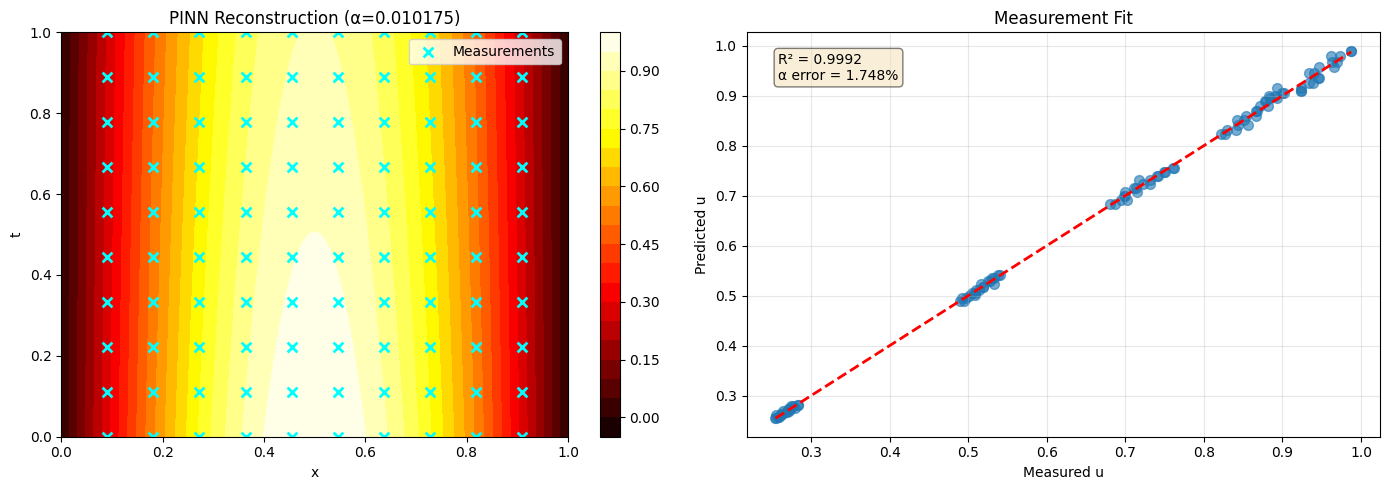

In [23]:
plot_solution(model_inverse_hard, data, alpha_true=0.01, save_path='../results/hard_vs_soft/inverse_5k_no_aw_reconstruct_hard.png')

### Hard constraints: adaptive weights

In [24]:
model_inverse_hard = HeatPINNHardBC(
    ic_func=lambda x: torch.sin(torch.pi * x),
    bc_left_func=lambda t: torch.zeros_like(t),
    bc_right_func=lambda t: torch.zeros_like(t),
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02
)

Inverse problem mode: alpha initialized to 0.02


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 6.537085e-01
  Residual: 4.748952e-01 (λ=1.00)
  Measurement: 1.788132e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Epoch 1000/5000 (60.6s)
  Adam learning rate: 1.00e-03
  Total Loss: 3.284981e-04
  Residual: 2.570384e-04 (λ=0.63)
  Measurement: 6.865354e-05 (λ=2.43)
  Alpha: 0.009756 (true: 0.01)

Switching to L-BFGS at epoch 1642
  Variance ratio: 0.099965 < 0.1
  Slope (log): |-0.000588| < 0.001

Final training plot:


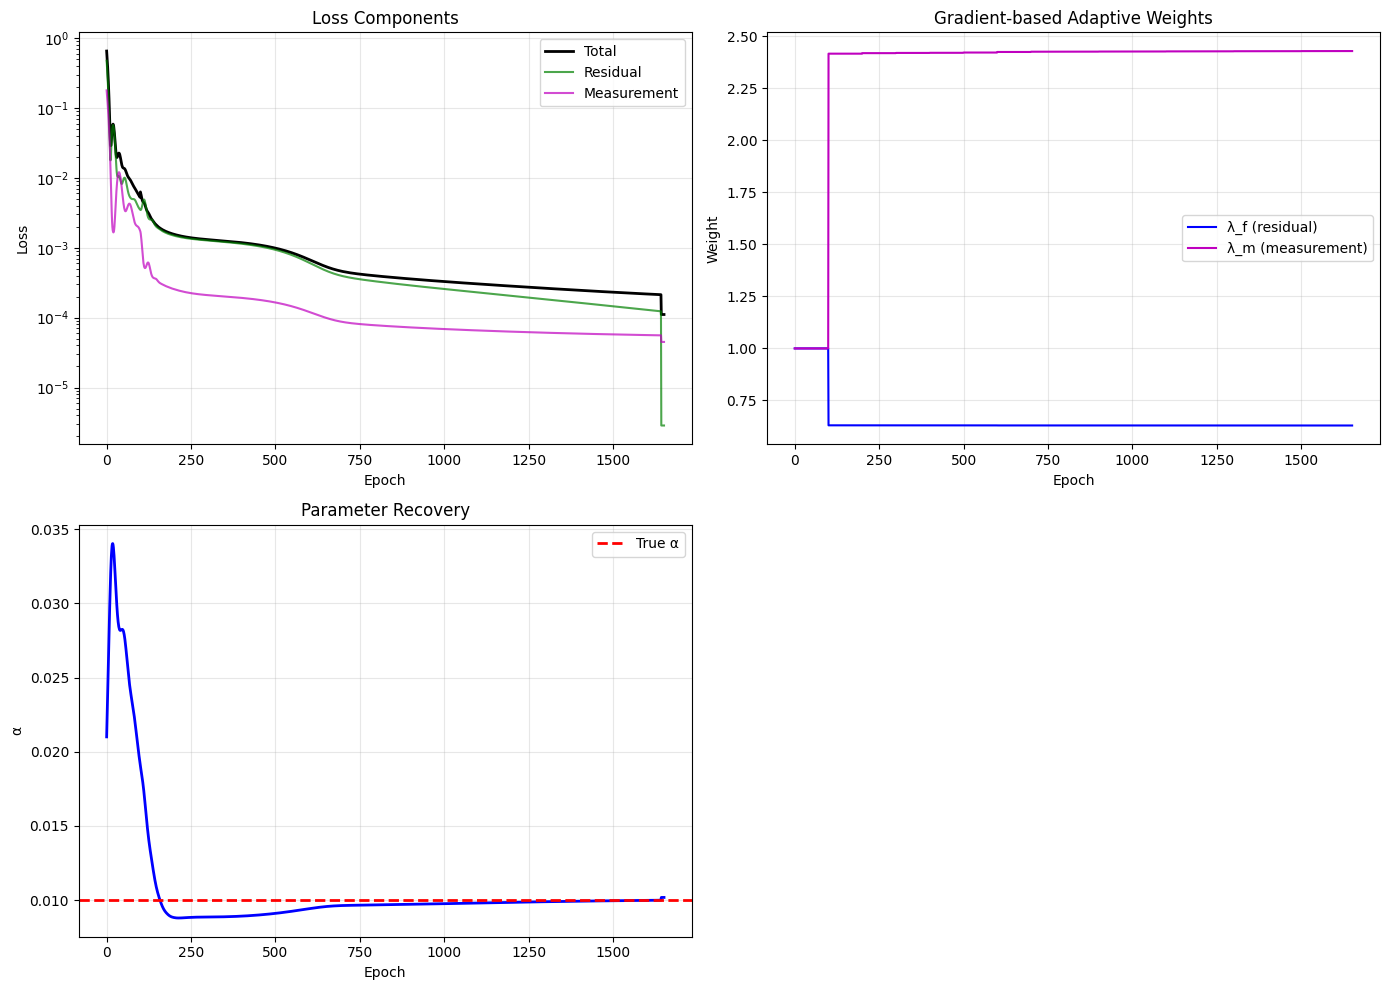

Max IC error (L1) after training: 0.0
Max BC errors (L1) after training: Left: 0.0, Right: 8.739888102127225e-08

Training complete. Total time: 109.4s


In [25]:
trainer_inverse_hard = PINNTrainerHardBC(
    model=model_inverse_hard,
    data=data,
    device='cpu',
    switch_var=0.1,
    switch_slope=0.001,
    adaptive_weights=True,
)

trainer_inverse_hard.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Evaluate

In [26]:
alpha_true = 0.01
alpha_pred = model_inverse_hard.get_alpha()
error_pct = abs(alpha_pred - alpha_true) / alpha_true * 100

print("\n" + "=" * 50)
print("INVERSE PROBLEM RESULTS")
print("=" * 50)
print(f"True α:        {alpha_true:.6f}")
print(f"Predicted α:   {alpha_pred:.6f}")
print(f"Error:         {error_pct:.2f}%")
print("=" * 50)

if error_pct < 5:
    print("SUCCESS: Parameter recovered within 5% error!")
else:
    print("Try training longer or adjusting hyperparameters")


INVERSE PROBLEM RESULTS
True α:        0.010000
Predicted α:   0.010178
Error:         1.78%
SUCCESS: Parameter recovered within 5% error!


Visualize

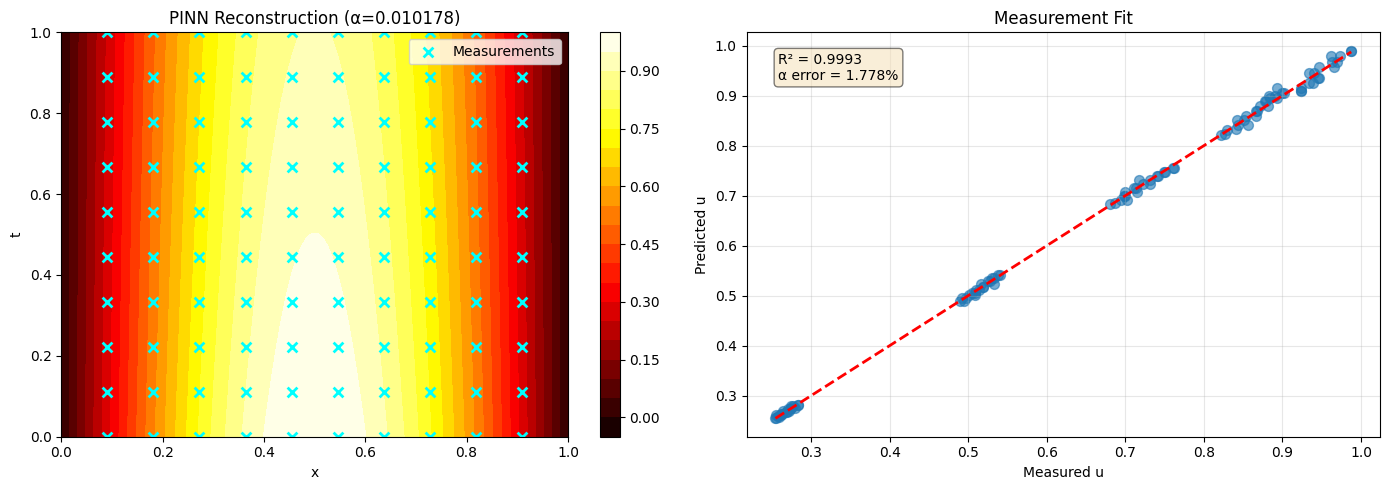

In [27]:
plot_solution(model_inverse_hard, data, alpha_true=0.01, save_path='../results/hard_vs_soft/inverse_5k_aw_reconstruct_hard.png')